# BEE 4750 Final Project

Team Members: Bailey Belinger (bcb87), Camila Monter (cm755), Priya Shah (ps742)

In [1]:
# Importing packages
import Pkg
# Pkg.activate(@__DIR__)
# Pkg.instantiate()
# Pkg.add("JuMP")
# Pkg.add("HiGHS")
# Pkg.add("DataFrames")
# Pkg.add("Plots")
# Pkg.add("Measures")
# Pkg.add("CSV")
# Pkg.add("MarkdownTables")

using JuMP
using HiGHS
using DataFrames
using Plots
using Measures
using CSV
using MarkdownTables
using LinearAlgebra

In [2]:
##Carbon Sequestration Rates

m2 = 0.092903 #conversion to m^2
#Trees
oak_tree_cs = 0.593 #kg C/m2/year
ash_tree_cs = 5.903 #kgC/m2/year
maple_tree_cs = 0.202 #kg C/m2/year

#Green Roof Systems
grass_cs = 0.2 #kg C/m2
prairie_mix_cs = 4.63 #kg C/m2
herb_garden_cs = 11.03 #kg C/m2

##Costs
#Trees
oak_tree_cost = 42.51 #per tree WHEN YOU BUY 10
ash_tree_cost = 109.75 #per tree
maple_tree_cost = 19.99 #per tree

#Green Roof Systems
installation_cost = 30*m2 #$/sqm
maintenance_cost = 1.50*m2 #$/sqm/year
grass_cost = 0.86*m2 #$/sqm
prairie_mix_cost = 0.03*m2 #$/sqm
herb_garden_cost = 9.50*m2 #$/sqm

#Available areas
city_area = (2526871.39-4101.84)*0.4 #m^2
park_area = 1563736.94 #m^2
total_area = city_area + park_area

#Emission rates in Chicago
current_emission_level = 0.0517 * total_area; #kg CO2 / year

### Initial Model

In [14]:
percent_reduction_goal = 30

air_quality_model = Model(HiGHS.Optimizer)
@variable(air_quality_model, G[1:6]>=0) #area in meters squared

fixed_cost = installation_cost*G[4] +  installation_cost*G[5] +  installation_cost*G[6] + maintenance_cost*G[4] + maintenance_cost*G[5] + maintenance_cost*G[6]
variable_cost = G[1]*oak_tree_cost + G[2]*ash_tree_cost + G[3]*maple_tree_cost + G[4]*grass_cost + G[5]*prairie_mix_cost + G[6]*herb_garden_cost
cost = fixed_cost + variable_cost
@objective(air_quality_model, Min, cost)

#print(air_quality_model)

emissions_reduction = (G[1]*oak_tree_cs + G[2]*ash_tree_cs + G[3]*maple_tree_cs + G[4]*grass_cs + G[5]*prairie_mix_cs + G[6]*herb_garden_cs)*(44/12) #kg CO2 / year
new_total_emissions = current_emission_level - emissions_reduction
percent_reduction = (current_emission_level - new_total_emissions)/current_emission_level * 100
@constraint(air_quality_model, emissions_constraint, percent_reduction >= percent_reduction_goal)
@constraint(air_quality_model, area_constraint_park, G[1]+G[2]+G[3] <= park_area)
@constraint(air_quality_model, area_constraint_rooftop, G[4]+G[5]+G[6] <= city_area)

# Optimize the model
optimize!(air_quality_model)

# Display the optimized values
println("Optimal oak trees ", value.(G[1])/15)
println("Optimal ash trees ", value.(G[2])/(15*m2))
println("Optimal maple trees ", value.(G[3])/(40*m2))
println("Optimal grass area ", value.(G[4]))
println("Optimal prarie mix area ", value.(G[5]))
println("Optimal herb garden area ", value.(G[6]))

Running HiGHS 1.8.0 (git hash: fcfb53414): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [6e-04, 1e+00]
  Cost   [3e+00, 1e+02]
  Bound  [0e+00, 0e+00]
  RHS    [3e+01, 2e+06]
Presolving model
3 rows, 6 cols, 12 nonzeros  0s
3 rows, 6 cols, 12 nonzeros  0s
Presolve : Reductions: rows 3(-0); columns 6(-0); elements 12(-0) - Not reduced
Problem not reduced by presolve: solving the LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 1(480) 0s
          1     3.7583050938e+03 Pr: 0(0) 0s
Model   status      : Optimal
Simplex   iterations: 1
Objective value     :  3.7583050938e+03
HiGHS run time      :          0.00
Optimal oak trees 0.0
Optimal ash trees 0.0
Optimal maple trees 0.0
Optimal grass area 0.0
Optimal prarie mix area 0.0
Optimal herb garden area 986.6847991659115


In [15]:
shadow_price(emissions_constraint)

-125.27683645911127

### Graphing Optimal Cost v. Percent Reduction

Running HiGHS 1.8.0 (git hash: fcfb53414): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [3e+00, 1e+02]
  Bound  [0e+00, 0e+00]
  RHS    [1e+06, 2e+06]
Presolving model
0 rows, 0 cols, 0 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve : Reductions: rows 0(-2); columns 0(-6); elements 0(-6) - Reduced to empty
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Objective value     :  0.0000000000e+00
HiGHS run time      :          0.00
Coefficient ranges:
  Matrix [6e-04, 1e+00]
  Cost   [3e+00, 1e+02]
  Bound  [0e+00, 0e+00]
  RHS    [1e+01, 2e+06]
Solving LP without presolve, or with basis, or unconstrained
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 1(10) 0s
          1     1.2527683646e+03 Pr: 0(0) 0s
Model   status      : Optimal
Simplex   iterations: 1
Objective value     :  1.2527683646e+03
HiGHS 

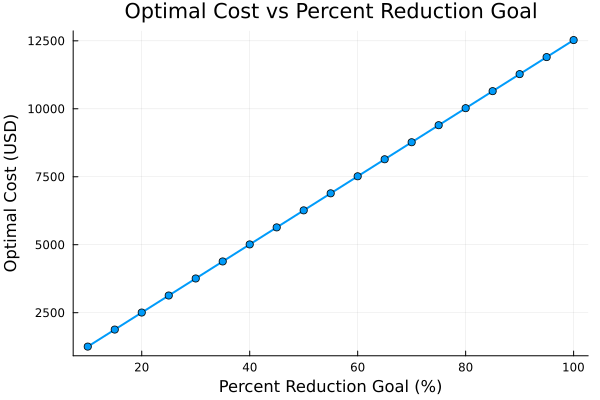

In [17]:
# Define the range of percent reduction goals
percent_reduction_goals = 10:5:100 # from 10% to 50% in increments of 5%
optimal_costs = []

air_quality_model = Model(HiGHS.Optimizer)
@variable(air_quality_model, G[1:6]>=0) #area in meters squared

fixed_cost = installation_cost*G[4] +  installation_cost*G[5] +  installation_cost*G[6] + maintenance_cost*G[4] + maintenance_cost*G[5] + maintenance_cost*G[6]
variable_cost = G[1]*oak_tree_cost + G[2]*ash_tree_cost + G[3]*maple_tree_cost + G[4]*grass_cost + G[5]*prairie_mix_cost + G[6]*herb_garden_cost
cost = fixed_cost + variable_cost
@objective(air_quality_model, Min, cost)

#print(air_quality_model)

emissions_reduction = (G[1]*oak_tree_cs + G[2]*ash_tree_cs + G[3]*maple_tree_cs + G[4]*grass_cs + G[5]*prairie_mix_cs + G[6]*herb_garden_cs)*(44/12) #kg CO2 / year
new_total_emissions = current_emission_level - emissions_reduction
percent_reduction = (current_emission_level - new_total_emissions)/current_emission_level * 100
@constraint(air_quality_model, area_constraint_park, G[1]+G[2]+G[3] <= park_area)
@constraint(air_quality_model, area_constraint_rooftop, G[4]+G[5]+G[6] <= city_area)

# Optimize the model
optimize!(air_quality_model)

# Loop over each percent reduction goal
for goal in percent_reduction_goals
    # Add a temporary constraint for the current percent reduction goal
    temp_constraint = @constraint(air_quality_model, percent_reduction >= goal)
    
    # Solve the model
    optimize!(air_quality_model)
    
    push!(optimal_costs, objective_value(air_quality_model))

    # Remove the temporary constraint before the next iteration
    delete(air_quality_model, temp_constraint)
end

# Plot the results
plot(percent_reduction_goals, optimal_costs, xlabel="Percent Reduction Goal (%)", ylabel="Optimal Cost (USD)",
    title="Optimal Cost vs Percent Reduction Goal", lw=2, marker=:circle, legend=false)

In [6]:
shadow_price(emissions_constraint)

-125.27683645911127

### Minimum Grass and Prairie Mix Area

In [12]:
#Herb Garden Constraint
percent_reduction_goal = 30

air_quality_model = Model(HiGHS.Optimizer)
@variable(air_quality_model, G[1:6]>=0) #area in meters squared

fixed_cost = installation_cost*G[4] +  installation_cost*G[5] +  installation_cost*G[6] + maintenance_cost*G[4] + maintenance_cost*G[5] + maintenance_cost*G[6]
variable_cost = G[1]*oak_tree_cost + G[2]*ash_tree_cost + G[3]*maple_tree_cost + G[4]*grass_cost + G[5]*prairie_mix_cost + G[6]*herb_garden_cost
cost = fixed_cost + variable_cost
@objective(air_quality_model, Min, cost)

#print(air_quality_model)

emissions_reduction = (G[1]*oak_tree_cs + G[2]*ash_tree_cs + G[3]*maple_tree_cs + G[4]*grass_cs + G[5]*prairie_mix_cs + G[6]*herb_garden_cs)*(44/12) #kg CO2 / year
new_total_emissions = current_emission_level - emissions_reduction
percent_reduction = (current_emission_level - new_total_emissions)/current_emission_level * 100
@constraint(air_quality_model, emissions_constraint, percent_reduction >= percent_reduction_goal)
@constraint(air_quality_model, area_constraint_park, G[1]+G[2]+G[3] <= park_area)
@constraint(air_quality_model, area_constraint_rooftop, G[4]+G[5]+G[6] <= city_area)
@constraint(air_quality_model, grass_constraint, G[4] >= 0.01*city_area)
@constraint(air_quality_model, prairie_mix_constraint, G[5] >= 0.01*city_area)

# Optimize the model
optimize!(air_quality_model)

# Display the optimized values
println("Optimal oak trees ", value.(G[1])/15)
println("Optimal ash trees ", value.(G[2])/(15*m2))
println("Optimal maple trees ", value.(G[3])/(40*m2))
println("Optimal grass area ", value.(G[4]))
println("Optimal prairie mix area ", value.(G[5]))
println("Optimal herb garden area ", value.(G[6]))

display(value.(percent_reduction))

Running HiGHS 1.8.0 (git hash: fcfb53414): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [6e-04, 1e+00]
  Cost   [3e+00, 1e+02]
  Bound  [0e+00, 0e+00]
  RHS    [3e+01, 2e+06]
Presolving model
3 rows, 6 cols, 12 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve : Reductions: rows 0(-5); columns 0(-6); elements 0(-14) - Reduced to empty
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Objective value     :  5.9896327975e+04
HiGHS run time      :          0.00
Optimal oak trees 0.0
Optimal ash trees 0.0
Optimal maple trees 0.0
Optimal grass area 10091.078200000002
Optimal prarie mix area 10091.078200000002
Optimal herb garden area 0.0


134.35443508759244

### Minimum Area of Diverse Trees

In [13]:
#Minimum area of diverse trees
percent_reduction_goal = 30

air_quality_model = Model(HiGHS.Optimizer)
@variable(air_quality_model, G[1:6]>=0) #area in meters squared

fixed_cost = installation_cost*G[4] +  installation_cost*G[5] +  installation_cost*G[6] + maintenance_cost*G[4] + maintenance_cost*G[5] + maintenance_cost*G[6]
variable_cost = G[1]*oak_tree_cost + G[2]*ash_tree_cost + G[3]*maple_tree_cost + G[4]*grass_cost + G[5]*prairie_mix_cost + G[6]*herb_garden_cost
cost = fixed_cost + variable_cost
@objective(air_quality_model, Min, cost)

#print(air_quality_model)

emissions_reduction = (G[1]*oak_tree_cs + G[2]*ash_tree_cs + G[3]*maple_tree_cs + G[4]*grass_cs + G[5]*prairie_mix_cs + G[6]*herb_garden_cs)*(44/12) #kg CO2 / year
new_total_emissions = current_emission_level - emissions_reduction
percent_reduction = (current_emission_level - new_total_emissions)/current_emission_level * 100
@constraint(air_quality_model, emisisons_constraint, percent_reduction >= percent_reduction_goal)
@constraint(air_quality_model, area_constraint_park, G[1]+G[2]+G[3] <= park_area)
@constraint(air_quality_model, area_constraint_rooftop, G[4]+G[5]+G[6] <= city_area)
@constraint(air_quality_model, minimum_oak, G[1] >=0.001*park_area)
@constraint(air_quality_model, minimum_ash, G[2] >= 0.001*park_area)
@constraint(air_quality_model, minimum_maple, G[3] >= 0.001*park_area)

# Optimize the model
optimize!(air_quality_model)

# Display the optimized values
println("Optimal oak trees ", value.(G[1])/15)
println("Optimal ash trees ", value.(G[2])/(15*m2))
println("Optimal maple trees ", value.(G[3])/(40*m2))
println("Optimal grass area ", value.(G[4]))
println("Optimal prairie mix area ", value.(G[5]))
println("Optimal herb garden area ", value.(G[6]))

display(value.(percent_reduction))

Running HiGHS 1.8.0 (git hash: fcfb53414): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [6e-04, 1e+00]
  Cost   [3e+00, 1e+02]
  Bound  [0e+00, 0e+00]
  RHS    [3e+01, 2e+06]
Presolving model
3 rows, 6 cols, 12 nonzeros  0s
3 rows, 6 cols, 12 nonzeros  0s
Presolve : Reductions: rows 3(-3); columns 6(-0); elements 12(-3)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     2.6935394544e+05 Pr: 1(18.0488) 0s
          1     2.6949500623e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 1
Objective value     :  2.6949500623e+05
HiGHS run time      :          0.00
Optimal oak trees 104.24912933333333
Optimal ash trees 1122.128772303729
Optimal maple trees 420.79828961389836
Optimal grass area 0.0
Optimal prarie mix area 0.0
Optimal herb garden area 37.10093478513159


30.0

### Minimum Area of Total Trees

In [19]:
#Minimum area of total trees
percent_reduction_goal = 30

air_quality_model = Model(HiGHS.Optimizer)
@variable(air_quality_model, G[1:6]>=0) #area in meters squared

fixed_cost = installation_cost*G[4] +  installation_cost*G[5] +  installation_cost*G[6] + maintenance_cost*G[4] + maintenance_cost*G[5] + maintenance_cost*G[6]
variable_cost = G[1]*oak_tree_cost + G[2]*ash_tree_cost + G[3]*maple_tree_cost + G[4]*grass_cost + G[5]*prairie_mix_cost + G[6]*herb_garden_cost
cost = fixed_cost + variable_cost
@objective(air_quality_model, Min, cost)

#print(air_quality_model)

emissions_reduction = (G[1]*oak_tree_cs + G[2]*ash_tree_cs + G[3]*maple_tree_cs + G[4]*grass_cs + G[5]*prairie_mix_cs + G[6]*herb_garden_cs)*(44/12) #kg CO2 / year
new_total_emissions = current_emission_level - emissions_reduction
percent_reduction = (current_emission_level - new_total_emissions)/current_emission_level * 100
@constraint(air_quality_model, emisisons_constraint, percent_reduction >= percent_reduction_goal)
@constraint(air_quality_model, area_constraint_park, G[1]+G[2]+G[3] <= park_area)
@constraint(air_quality_model, area_constraint_rooftop, G[4]+G[5]+G[6] <= city_area)
@constraint(air_quality_model, minimum_total_trees, G[1]+G[2]+G[3] >=0.001*park_area)

# Optimize the model
optimize!(air_quality_model)

# Display the optimized values
println("Optimal oak trees ", value.(G[1])/15)
println("Optimal ash trees ", value.(G[2])/(15*m2))
println("Optimal maple trees ", value.(G[3])/(40*m2))
println("Optimal grass area ", value.(G[4]))
println("Optimal prairie mix area ", value.(G[5]))
println("Optimal herb garden area ", value.(G[6]))

Running HiGHS 1.8.0 (git hash: fcfb53414): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [6e-04, 1e+00]
  Cost   [3e+00, 1e+02]
  Bound  [0e+00, 0e+00]
  RHS    [3e+01, 2e+06]
Presolving model
4 rows, 6 cols, 15 nonzeros  0s
3 rows, 6 cols, 12 nonzeros  0s
Presolve : Reductions: rows 3(-1); columns 6(-0); elements 12(-3)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 2(577.734) 0s
          2     3.4908324510e+04 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 2
Objective value     :  3.4908324510e+04
HiGHS run time      :          0.01
Optimal oak trees 0.0
Optimal ash trees 0.0
Optimal maple trees 420.79828961389836
Optimal grass area 0.0
Optimal prairie mix area 0.0
Optimal herb garden area 958.0470057044428


### Percent Reduction Based on Budget

In [10]:
budget = 128010.77

air_quality_model = Model(HiGHS.Optimizer)
@variable(air_quality_model, G[1:6]>=0) #area in meters squared

fixed_cost = installation_cost*G[4] +  installation_cost*G[5] +  installation_cost*G[6] + maintenance_cost*G[4] + maintenance_cost*G[5] + maintenance_cost*G[6]
variable_cost = G[1]*oak_tree_cost + G[2]*ash_tree_cost + G[3]*maple_tree_cost + G[4]*grass_cost + G[5]*prairie_mix_cost + G[6]*herb_garden_cost
cost = fixed_cost + variable_cost


emissions_reduction = (G[1]*oak_tree_cs + G[2]*ash_tree_cs + G[3]*maple_tree_cs + G[4]*grass_cs + G[5]*prairie_mix_cs + G[6]*herb_garden_cs)*(44/12) #kg CO2 / year
new_total_emissions = current_emission_level - emissions_reduction
percent_reduction = (current_emission_level - new_total_emissions)/current_emission_level * 100

@objective(air_quality_model, Max, percent_reduction)

@constraint(air_quality_model, area_constraint_park, G[1]+G[2]+G[3] <= park_area)
@constraint(air_quality_model, area_constraint_rooftop, G[4]+G[5]+G[6] <= city_area)
@constraint(air_quality_model, budget_constraint, cost <= budget)

optimize!(air_quality_model)

# Display the optimized values
println("Optimal oak trees ", value.(G[1])/15)
println("Optimal ash trees ", value.(G[2])/(15*m2))
println("Optimal maple trees ", value.(G[3])/(40*m2))
println("Optimal grass area ", value.(G[4]))
println("Optimal prairie mix area ", value.(G[5]))
println("Optimal herb garden area ", value.(G[6]))

Running HiGHS 1.8.0 (git hash: fcfb53414): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 1e+02]
  Cost   [6e-04, 3e-02]
  Bound  [0e+00, 0e+00]
  RHS    [1e+05, 2e+06]
Presolving model
3 rows, 6 cols, 12 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve : Reductions: rows 0(-3); columns 0(-6); elements 0(-12) - Reduced to empty
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Objective value     :  1.0218231368e+03
HiGHS run time      :          0.00
Optimal oak trees 0.0
Optimal ash trees 0.0
Optimal maple trees 0.0
Optimal grass area 0.0
Optimal prarie mix area 0.0
Optimal herb garden area 33607.2452174744


Running HiGHS 1.8.0 (git hash: fcfb53414): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [6e-04, 1e+02]
  Cost   [6e-04, 3e-02]
  Bound  [0e+00, 0e+00]
  RHS    [1e+02, 2e+06]
Presolving model
4 rows, 6 cols, 18 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve : Reductions: rows 0(-4); columns 0(-6); elements 0(-18) - Reduced to empty
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Objective value     :  7.9823216188e+00
HiGHS run time      :          0.00
Coefficient ranges:
  Matrix [6e-04, 1e+02]
  Cost   [6e-04, 3e-02]
  Bound  [0e+00, 0e+00]
  RHS    [1e+02, 2e+06]
Presolving model
4 rows, 6 cols, 18 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve : Reductions: rows 0(-4); columns 0(-6); elements 0(-18) - Reduced to empty
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Objective value     :  1.5964643238e+01
HiGHS run time      :          0.00
Coefficient ranges

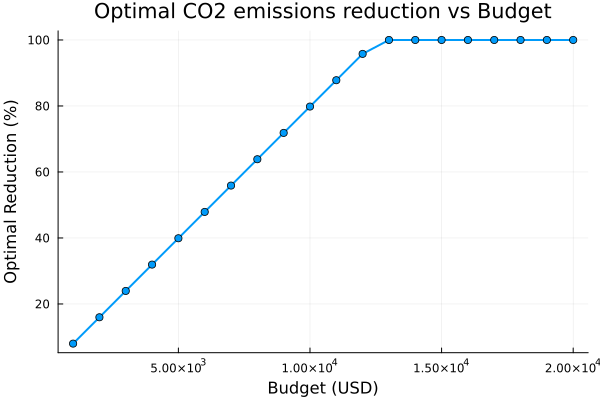

In [18]:
# Define the range of budget constraints
budget_constraints = 1000:1000:20000 # from $___ to $____ in increments of $____
optimal_reduction = []

air_quality_model = Model(HiGHS.Optimizer)
@variable(air_quality_model, G[1:6]>=0) #area in meters squared

fixed_cost = installation_cost*G[4] +  installation_cost*G[5] +  installation_cost*G[6] + maintenance_cost*G[4] + maintenance_cost*G[5] + maintenance_cost*G[6]
variable_cost = G[1]*oak_tree_cost + G[2]*ash_tree_cost + G[3]*maple_tree_cost + G[4]*grass_cost + G[5]*prairie_mix_cost + G[6]*herb_garden_cost
cost = fixed_cost + variable_cost

emissions_reduction = (G[1]*oak_tree_cs + G[2]*ash_tree_cs + G[3]*maple_tree_cs + G[4]*grass_cs + G[5]*prairie_mix_cs + G[6]*herb_garden_cs)*(44/12) #kg CO2 / year
new_total_emissions = current_emission_level - emissions_reduction
percent_reduction = (current_emission_level - new_total_emissions)/current_emission_level * 100

@objective(air_quality_model, Max, percent_reduction)

@constraint(air_quality_model, area_constraint_park, G[1]+G[2]+G[3] <= park_area)
@constraint(air_quality_model, area_constraint_rooftop, G[4]+G[5]+G[6] <= city_area)
@constraint(air_quality_model, percent_red_constraint, percent_reduction <= 100)

# Loop over each budget constraint
for goal in budget_constraints
    # Add a temporary constraint for the current budget
    temp_constraint = @constraint(air_quality_model, cost <= goal)
    
    # Solve the model
    optimize!(air_quality_model)
    
    push!(optimal_reduction, objective_value(air_quality_model))

    # Remove the temporary constraint before the next iteration
    delete(air_quality_model, temp_constraint)
end

# Plot the results
plot(budget_constraints, optimal_reduction, xlabel="Budget (USD)", ylabel="Optimal Reduction (%)",
    title="Optimal CO2 emissions reduction vs Budget", lw=2, marker=:circle, legend=false)